In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras import models, layers, regularizers, Sequential, Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense, Input, Resizing, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

# **1. Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNEL = 3

In [4]:
# load và chia batch
ds = image_dataset_from_directory(
  directory='/content/drive/MyDrive/colab-notebooks/crop-disease-classification/dataset/Potato',
  seed=123,       # kết quả giống nhau mỗi lần xáo trộn
  shuffle = True,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),  # resize 224x224
  batch_size = BATCH_SIZE,
)

ds # ((imgs, labels), ...)

Found 1510 files belonging to 3 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
classes = ds.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
total_batch = len(ds)  # 1510/BATCH_SIZE
total_batch

48

In [7]:
first_batch = ds.take(1) # ((imgs, labels))
len(first_batch)

1

In [8]:
for imgs, label_indexes in ds.take(1):
    print("Imgs shape:", imgs.shape)  # 4D (batch, H, W, C)
    print("Labels:", label_indexes.shape, "\n", label_indexes.numpy)  # 1D, label_indexes.numpy()
    print("Img shape:", imgs[0].shape)  # 3D (H, W, C)

Imgs shape: (32, 224, 224, 3)
Labels: (32,) 
 <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 1, 0, 2, 2, 2, 2, 0, 2, 1, 1, 0, 1, 2, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 2, 2, 1, 2, 2, 0], dtype=int32)>>
Img shape: (224, 224, 3)


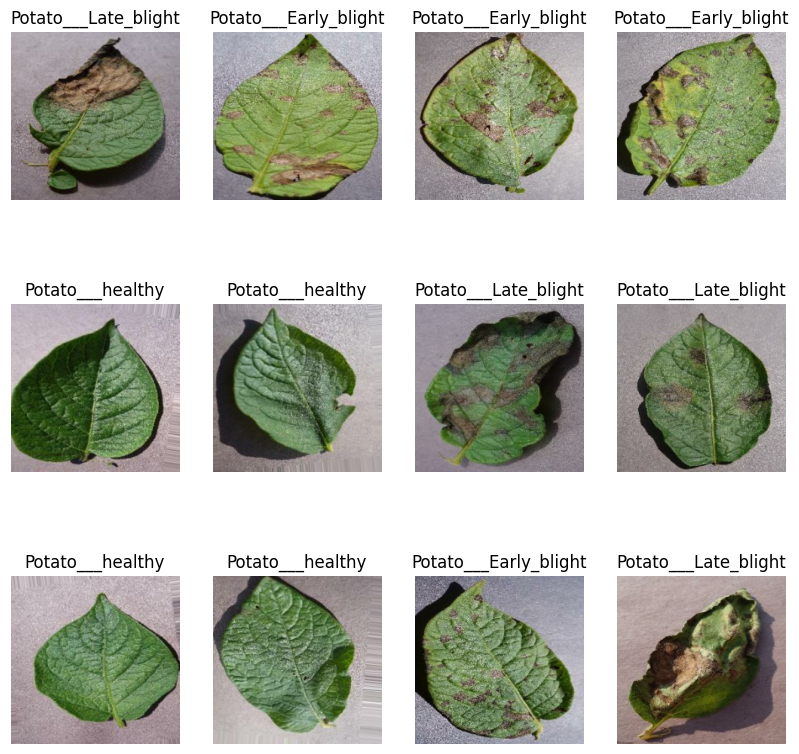

In [9]:
def display_imgs():
  plt.figure(figsize=(10, 10)) #10 inch × 10 inch

  for images, labels in ds.take(1):
      for item in range(12):
          ax = plt.subplot(3, 4, item + 1) # vẽ trục: 3x4, bắt đầu từ ô thứ 1
          plt.imshow(images[item].numpy().astype("uint8"))
          plt.title(classes[labels[item]])
          plt.axis("off")

display_imgs()

# **#. Encode**
- chuyển non-numeric sang numeric

In [10]:
ds = ds.map(
    lambda imgs, labels: (imgs, one_hot(indices=labels, depth=len(classes), dtype=tf.float32))
)

In [11]:
for images, labels in ds.take(1):
    print("Images shape:", images.shape)   # 4D
    print("Labels encoded:", labels[:5])   # 2D: (rows, columns)

Images shape: (32, 224, 224, 3)
Labels encoded: tf.Tensor(
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)


# **#. Split**

In [12]:
def split_dataset (ds, train_size=0.85, val_size=0.13, test_size=0.02, shuffle=True, shuffle_size=1000):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6

    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=123)

    ds = ds.cache()   # load vào đệm

    train_length = round(len(ds) * train_size)
    val_length = round(len(ds) * val_size)
    test_length = round(len(ds) * test_size)

    ds = ds.enumerate()

    train_ds = (ds.filter(lambda i, _: i < train_length).map(lambda _, batch: batch))
    val_ds = (ds.filter(lambda i, _: train_length <= i < train_length + val_length).map(lambda _, batch: batch))
    test_ds = (ds.filter(lambda i, _: train_length + val_length <= i).map(lambda _, batch: batch))

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(ds)

# **#. Scale**
- scale pixel về [0,1]

In [13]:
def scale_images(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

# train_ds = train_ds.map(scale_images, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000)
# val_ds = val_ds.map(scale_images, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.map(scale_images, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = train_ds.map(scale_images)
val_ds = val_ds.map(scale_images)
test_ds = test_ds.map(scale_images)

# **#. Tăng cường dữ liệu**
- chỉ đc tăng cường cho tập train

In [14]:
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label

# train_ds = train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
train_ds = train_ds.map(augment_data)

# **2. Model**

In [15]:
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL))

# 32 kernel
res = Conv2D(32, (3, 3), activation='relu')(inputs)
res = MaxPooling2D((2, 2))(res)

res = Conv2D(64, (3, 3), activation='relu')(res)
res = MaxPooling2D((2, 2))(res)

res = Conv2D(64, (3, 3), activation='relu')(res)
res = MaxPooling2D((2, 2))(res)

res = Conv2D(64, (3, 3), activation='relu')(res)
res = MaxPooling2D((2, 2))(res)

res = Conv2D(64, (3, 3), activation='relu')(res)
res = MaxPooling2D((2, 2))(res)

res = Flatten()(res)

# fully-connected, 64 notron
res = Dense(64, activation='relu')(res)

# output-layer: softmax phân loại nhiều lớp
outputs = Dense(len(classes), activation='softmax')(res)  # 3 notron cho 3 lớp

model = Model(inputs=inputs, outputs=outputs)

In [16]:
model.compile(
    optimizer='adam',
    # CategoricalCrossentropy one-hot, from_logits=False: ko tính softmax (vì đã tính trc đó)
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']  # tỷ lệ dự đoán đúng so với tổng số dự đoán
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [17]:
# fit và train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=100,
    # steps_per_epoch = length_of_train,
    # validation_steps = length_of_val,
    callbacks=[early_stopping]
)

Epoch 1/100
     41/Unknown 214s 157ms/step - accuracy: 0.3394 - loss: 1.0945

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 215s 193ms/step - accuracy: 0.3396 - loss: 1.0945 - val_accuracy: 0.3125 - val_loss: 1.0958
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 54s 123ms/step - accuracy: 0.3531 - loss: 1.0909 - val_accuracy: 0.6250 - val_loss: 1.0220
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.5745 - loss: 0.9725 - val_accuracy: 0.6979 - val_loss: 0.7641
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.6300 - loss: 0.8329 - val_accuracy: 0.6406 - val_loss: 0.8628
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.6382 - loss: 0.7893 - val_accuracy: 0.6042 - val_loss: 0.7822
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.6693 - loss: 0.7367 - val_accuracy: 0.7396 - val_loss: 0.5814
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.6643 - loss: 0.6876 - val_accuracy: 0.8438 - val_loss: 0.4316
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7472 - loss: 0.5587 - val_accuracy: 

# **3. Save**

In [18]:
model.save("/content/drive/MyDrive/colab-notebooks/crop-disease-classification/model/model.keras")

# **4. Đánh giá**

In [19]:
model = models.load_model('/content/drive/MyDrive/colab-notebooks/crop-disease-classification/model/model.keras')

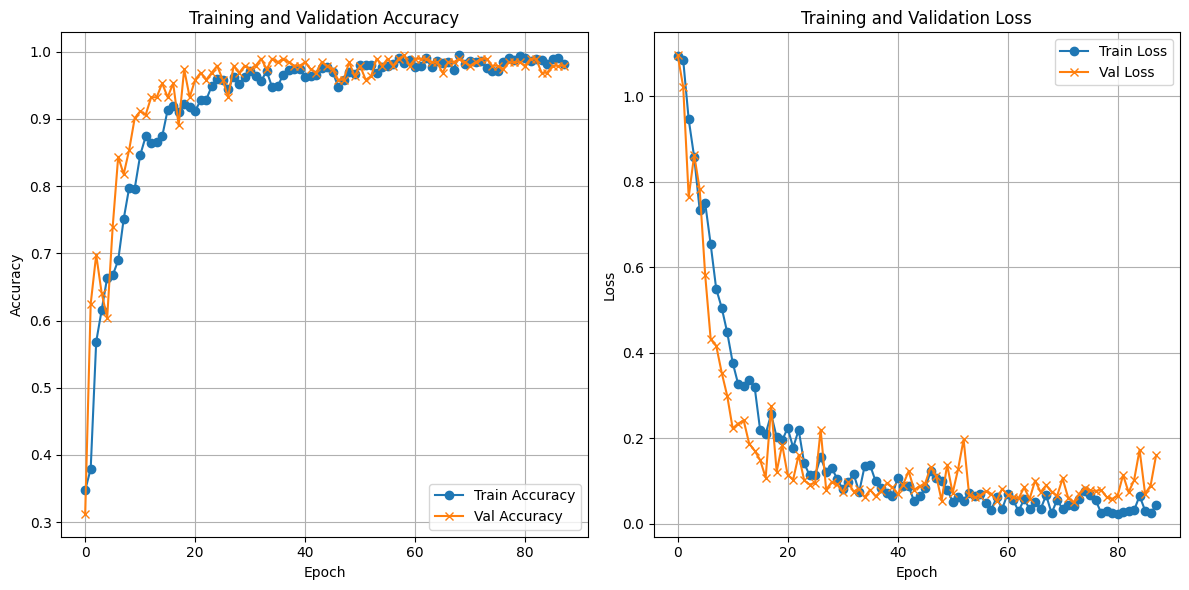

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
def display(images, labels, Y_predict):
    for i in range(12):
        actual_label = classes[np.argmax(labels[i])]

        predicted_label = classes[np.argmax(Y_predict[i])]  # lấy chỉ mục của giá trị lớn nhất

        predicted_probability = round(np.max(Y_predict[i]) * 100, 2) # chuyển về %

        ax = plt.subplot(3, 4, i + 1)
        plt.title(f"Actual: {actual_label},\n Predicted: {predicted_label}.\n Predicted probability: {predicted_probability:.2f}%")
        plt.axis("off")
        plt.imshow(images[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


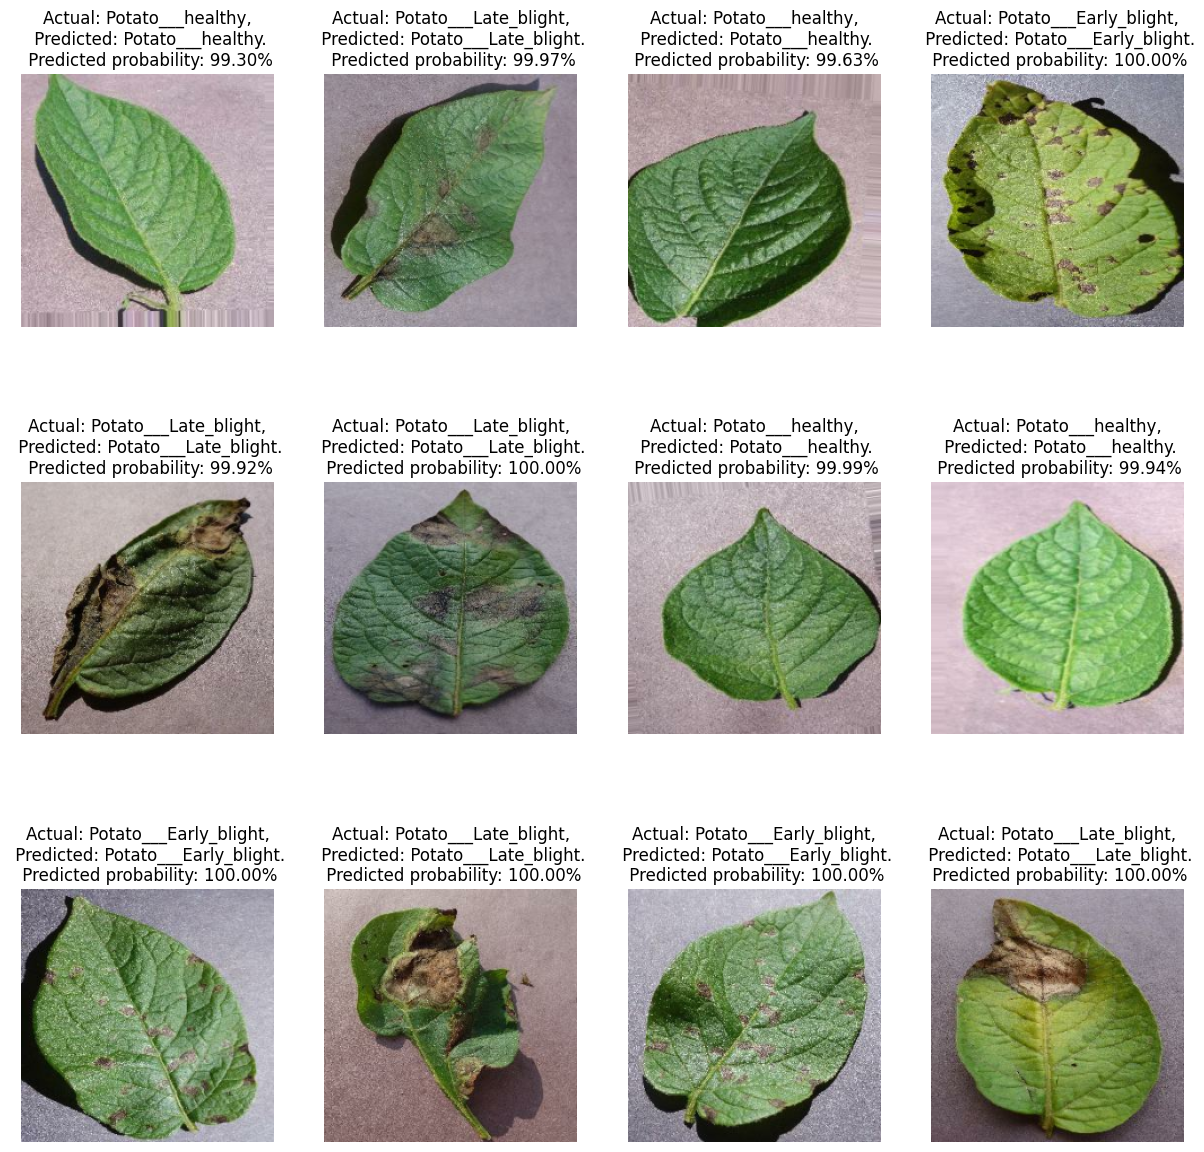

In [22]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds:
    Y_predict = model.predict(images) # 2D
    display(images, labels, Y_predict)